In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("Twitter_Data.csv")
df = df.rename(columns={col: col.strip() for col in df.columns})
df = df[['clean_text', 'category']].dropna()
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z0-9\s\.\,\!\?\'\"]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['clean_text'].map(clean_text)
df['category'] = df['category'].astype(int)


In [4]:
X = df['clean_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=30000, min_df=5)),
    ("clf", LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=42))
])

param_grid = {"clf__C": [0.1, 1.0, 5.0]}

gs = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
gs.fit(X_train, y_train)

best = gs.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits


              precision    recall  f1-score   support

          -1     0.8862    0.9078    0.8969      5326
           0     0.9399    0.9739    0.9566      8282
           1     0.9639    0.9256    0.9444     10838

    accuracy                         0.9381     24446
   macro avg     0.9300    0.9358    0.9326     24446
weighted avg     0.9388    0.9381    0.9382     24446



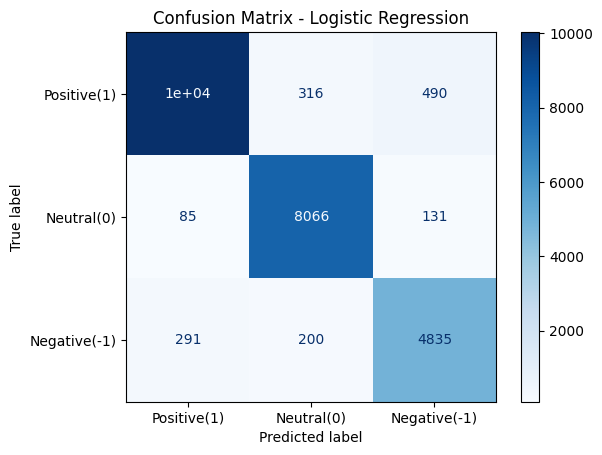

In [5]:
y_pred = best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=[1,0,-1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive(1)","Neutral(0)","Negative(-1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [6]:
joblib.dump(best, "tfidf_logreg_sentiment.joblib")

sample_texts = [
    "I love this product, works perfectly!",
    "It was okay, nothing special.",
    "Terrible experience, I want a refund."
]

for t in sample_texts:
    pred = best.predict([clean_text(t)])[0]
    print(f"Text: {t}\nPredicted Sentiment: {pred}\n")


Text: I love this product, works perfectly!
Predicted Sentiment: 1

Text: It was okay, nothing special.
Predicted Sentiment: 1

Text: Terrible experience, I want a refund.
Predicted Sentiment: -1

